In [1]:
import os
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch 
from  torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
f'torch.__version__ : {torch.__version__}'

'torch.__version__ : 0.4.1'

## データの格納

In [3]:
df_data_ = pd.read_csv('drive_data.csv')
df_data = df_data_.dropna()

In [4]:
print(f'男性 ： {np.count_nonzero(df_data.Sex == 0)}名')
print(f'女性 ： {np.count_nonzero(df_data.Sex == 1)}名')

男性 ： 63名
女性 ： 18名


In [5]:
sample = []
col = ['Age', 'MMSE', 'Kohs_IQ', 'TMT_A', 'TMT_B', 
       'CAT1_time', 'CAT1_responce', 'CAT2_time', 'CAT2_responce',
       'CAT3_time', 'CAT3_responce', 'CAT4_time', 'CAT4_responce']
for i, n in enumerate(col):
    sample.append(df_data[n])

In [6]:
sample_data = pd.DataFrame(sample).T
sample_data.index = range(len(sample_data))
sample_target= np.array(df_data[df_data.columns[-1]])

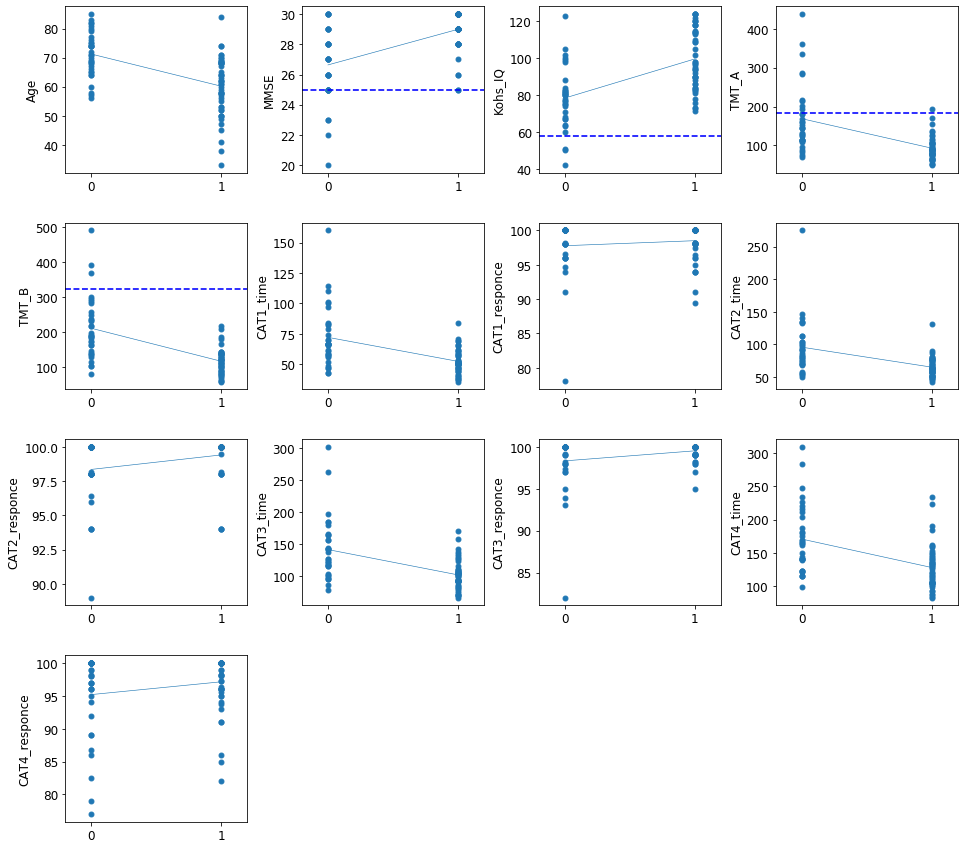

In [7]:
from sklearn import linear_model

def f(t): return model.coef_[0] * t + model.intercept_

k = 0.2
fig = plt.figure(figsize = (80*k, 75*k))
plt.rcParams["font.size"] = 60*k
plt.subplots_adjust(wspace = 0.3, hspace = 0.3) 

for i, n in enumerate(sample_data.columns):
    if n == 'MMSE':
        cut = 25
    elif n == 'Kohs_IQ':
        cut = 58
    elif n == 'TMT_A':
        cut = 183 
    elif n == 'TMT_B':
        cut = 324
    else:
        cut = None
        
    a = np.array(sample_data[n])
    b = np.array(sample_target)
    model = linear_model.LinearRegression()
    model.fit(b.reshape(-1, 1), a)
    xmin = b.min()
    xmax = b.max()

    plt.subplot(4, len(sample_data.columns)//4+ 1, i+1)
    plt.scatter(b, a, s = 120*k)
    plt.plot([xmin, xmax], [f(xmin), f(xmax)], linewidth = 3*k)
    plt.plot([-0.2, 1.2], [cut, cut],'--',c = 'b', linewidth = 8*k)
    plt.xlim(-0.2, 1.2)
    plt.ylabel(f'{n}')
    plt.xticks(range(2), range(2))

## Deeplearning

In [8]:
os.getcwd()

'/Users/ryoutahosomi/Documents/GitHub/deep_learning_Classification_driving'

In [9]:
X = np.array(sample_data)
Y = np.array(sample_target)

100%|██████████| 1000/1000 [00:03<00:00, 289.75it/s]


Epoch:0/1000 Error_train:4.398100733757019 Error_test:0.9644846320152283
Epoch:100/1000 Error_train:1.377697229385376 Error_test:0.6089386940002441
Epoch:200/1000 Error_train:1.0703680515289307 Error_test:0.3646799623966217
Epoch:300/1000 Error_train:0.9490337371826172 Error_test:0.2740144431591034
Epoch:400/1000 Error_train:0.8295879364013672 Error_test:0.20619453489780426
Epoch:500/1000 Error_train:0.7180093824863434 Error_test:0.23352645337581635
Epoch:600/1000 Error_train:0.8217031359672546 Error_test:0.18485823273658752
Epoch:700/1000 Error_train:0.7259038686752319 Error_test:0.2133278250694275
Epoch:800/1000 Error_train:0.9456633031368256 Error_test:0.25775161385536194
Epoch:900/1000 Error_train:0.6853401064872742 Error_test:0.18634164333343506
Epoch:1000/1000 Error_train:0.7613401710987091  Error_test:0.17654651403427124


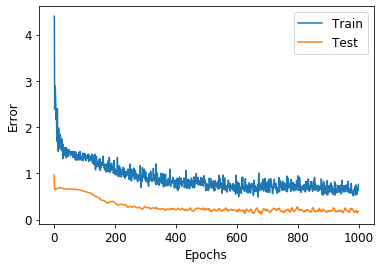

Accuracy Train : 92.1875 % Accuracy Test : 88.23529411764706 % Accuracy all : 91.35802469135803 %


In [10]:
input_data = X
correct = Y
n_data = len(correct) 

X_train, X_test, Y_train, Y_test = train_test_split(input_data, correct, test_size = 0.2)

x_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(Y_train, dtype = torch.int64)

x_test = torch.tensor(X_test, dtype = torch.float32)
y_test = torch.tensor(Y_test, dtype = torch.int64)

n_train = x_train.shape[0]
n_test = x_test.shape[0]

n_in = len(col)
n_mid = 64 
n_out = 2

epoch = 1000
batch_Size = 32
interval = epoch/10 

## newralnetwork
class CustomLinesr(nn.Module):
    def __init__ (self, n_in,
                 n_out,
                 bias = True, p = 0.5):
        super().__init__()
        self.linear = nn.Linear(n_in,
                               n_out,
                               bias)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p)
    
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.drop(x)
        return x
    
class MyMLP(nn.Module):
    def __init__ (self, in_features,
                 out_features,
                 bias = True, p = 0.5):
        super().__init__()
        self.ln1 = CustomLinesr(n_in, n_mid)
        self.ln2 = CustomLinesr(n_mid, n_mid)
        self.ln3 = CustomLinesr(n_mid, n_mid)
        self.ln4 = CustomLinesr(n_mid, n_mid)
        self.ln5 = CustomLinesr(n_mid, n_mid)
        self.ln6 = CustomLinesr(n_mid, n_out)
    
    def forward(self, x):
        x = self.ln1(x)
        x = self.ln2(x)
        x = self.ln3(x)
        x = self.ln4(x)
        x = self.ln5(x)
        out = self.ln6.linear(x)
        return out
    
net = MyMLP(n_in, n_out)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

ds = TensorDataset(x_train, y_train)
loader = DataLoader(ds, batch_size = batch_Size, shuffle = True)

# -- 誤差の記録用 --
train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

for n in tqdm.tqdm(range(epoch)):
    running_loss = 0.
    # ネットワークを訓練モードにする
    net.train()
    for i, (xx, yy) in enumerate(loader):
        y_pred = net(xx)
        loss = loss_fn(y_pred, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_error_x.append(n)
    train_error_y.append(running_loss)
    net.eval()
    y_pred = net(x_test)
    test_loss = loss_fn(y_pred, y_test)
    test_error_x.append(n)
    test_error_y.append(test_loss.item()) 

for i, (xx, yy) in enumerate(zip(train_error_y, test_error_y)):
    # -- 経過の表示 -- 
    if i%interval == 0:
        print("Epoch:" + str(i) + "/" + str(epoch) + " Error_train:" + str(xx),"Error_test:" + str(float(yy)))
print("Epoch:1000/" + str(epoch) + " Error_train:" + str(float(train_error_y[-1])),
              " Error_test:" + str(float(test_error_y[-1])))
        
# -- 誤差の記録をグラフ表示 -- 
fig = plt.figure(figsize = (30*k, 20*k))
plt.rcParams["font.size"] = 60*k
plt.plot(train_error_x, train_error_y, label="Train")
plt.plot(test_error_x, test_error_y, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")

plt.show()

def Accuary(x, y):
    h = net(x)
    _, y_pred = torch.max(h,1)
    return (y_pred == y).sum().item()/len(y)
print(f"Accuracy Train : {Accuary(x_train, y_train)*100} %", f"Accuracy Test : {Accuary(x_test, y_test)*100} %",f"Accuracy all : {Accuary(torch.tensor(input_data, dtype = torch.float32), torch.tensor(correct, dtype = torch.int64))*100} %" )